In [1]:
### TODO:
#   - !!najdi primerni podatkovni bazi za regresijo in klasifikacijo
#   - omogoči naključno rezanje uteži
#   - !!ustvari lažje podajanje hiperparametrov
#   - !!ročno inicializiraj uteži z Gaussian Glorot initialization ALI Gaussian z standard deviation 0.1
#   - !!ustvari lepši ui, ki na boljši način prikaže rezanje in učenje.
#   - podatke kot je early stopping rate, natančnost itd. itd. je treba nekje shraniti in prikazati
#   - !!sproti shranjuj nekatere modele npr. najbolj natančnega, najbolj rezanega ali po vsakem rezanjuž
#   - !!dodaj dve opciji globalno prunanje ali prunanje po sloju
#   - !!izboljšaj early stoppage tako da si shraniš model kot je val večji in ga nato loadaš v primeru če se je učenje prenehalo zaradi early stoppage
#   - v statistiko še dodaj druge metrike kot precision recall in F1
#   - dodaj možnost kjer prunaš samo nekatere uteži npr. samo convolution layerje
#   - !!popravi napako, kjer se zadnja epoha ne pokaže pre early stoppage
#   - Ko šteješ koliko ničel in neničel je štej rajši z maske

### TODO:
#   - probaj densenet brez pretrained uteži
#   - probaj preprečiti rezanje batch norm plasti v densenet
#   - poglej kaki bodo rezultati če znižaš resolucijo slik
#   - probaj znižati learning rate na 1e-5
#   - probaj ročno spremeniti število izhodov za zadnji layer

## NEKAJ JE NAROBE PRI ALEXNET NORMAL WEIGHTS

#POMEMBNO: Za errror pri squeezenet1_1 je kriva glorotova inicializacija uteži

In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from dataset_realwaste import *
from dataset_chest_xray import *
from iterative_pruning import IterativePruning

#from torchvision.models import squeezenet1_1
#from torchvision.models import densenet121
from torchvision.models import resnet18
from torchvision.models import alexnet
#from torchvision.models import vgg16
#from torchvision.models import efficientnet_v2_s
from torchvision.models import shufflenet_v2_x1_0

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
NUM_CHANNELS = 1
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_PRUNE_ITER = 2
PRUNE_PER = 0.2
IMAGE_SIZE = [256,256] #[256,256] #[524, 524]  #[28, 28]
LR = 1e-3 #1e-4 #1.2e-3

In [ ]:
## MNIST

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.expand(3, -1, -1)),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
## REALWASTE

inputs, targets, label_encoder = getRealWasteDataset()

train_size = int(0.7 * len(inputs))
val_size = int(0.15 * len(inputs))
test_size = len(inputs) - train_size - val_size

train_dataset = RealWasteDataset(inputs[:train_size,:], targets[:train_size], IMAGE_SIZE, True)
val_dataset = RealWasteDataset(inputs[train_size : train_size + val_size,:], targets[train_size : train_size + val_size], IMAGE_SIZE, False)
test_dataset = RealWasteDataset(inputs[-test_size:,:], targets[-test_size:], IMAGE_SIZE, False)

#train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(real_waste_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(1))

#for input, target in train_dataset.dataset:
#    train_dataset.dataset += [(torchvision.transforms.functional.hflip(input), target)]
#    train_dataset.dataset += [(torchvision.transforms.functional.rotate(input, -90), target)]

train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = BATCH_SIZE)


In [4]:
## CHEST XRAY
chest_xray_dataset = ChestXRayDataset("./data/kaggle/kaggle/train3", "./data/train_age.csv", IMAGE_SIZE)

train_size = int(0.7 * len(chest_xray_dataset))
val_size = int(0.15 * len(chest_xray_dataset))
test_size = len(chest_xray_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(chest_xray_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = BATCH_SIZE)

Velikost učne množice:   7491
Velikost validacijske množice:   1605
Velikost testne množice:   1606
Dimenzija slik: (3, 256, 256)


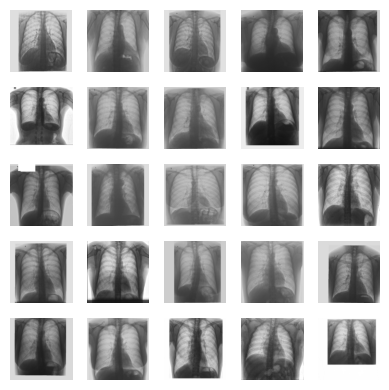

In [5]:
input, targets = next(iter(train_loader))

print(f"Velikost učne množice:   {len(train_dataset)}")
print(f"Velikost validacijske množice:   {len(val_dataset)}")
print(f"Velikost testne množice:   {len(test_dataset)}")
print(f"Dimenzija slik: {input[0].numpy().shape}")

#string_decoded = label_encoder.inverse_transform(targets.ravel())
#print(string_decoded)

dim = int(len(input) ** 0.5)

_, axes = plt.subplots(dim, dim, figsize=(4, 4), squeeze=False)
for i in range(dim):
    for j in range(dim):
        axes[i, j].imshow(input[dim * i + j].numpy().transpose((1,2,0)), cmap="gray")
        axes[i, j].axis("off")
            
plt.tight_layout()

In [6]:
#model = LeNet300(3 * IMAGE_SIZE[0] * IMAGE_SIZE[1], NUM_CHANNELS)

#model = densenet121(weights=None)
#num_ftrs = model.classifier.in_features
#model.classifier = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

model = resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#model = alexnet(weights=None)
#num_ftrs = model.classifier[6].in_features
#model.classifier[6] = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#model = vgg16(weights=None)
#num_ftrs = model.classifier[6].in_features
#model.classifier[6] = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#model = efficientnet_v2_s(weights=None)
#num_ftrs = model.classifier[1].in_features
#model.classifier[1] = torch.nn.Linear(num_ftrs, NUM_CHANNELS)ž

#model = shufflenet_v2_x1_0(weights=None)
#num_ftrs = model.fc.in_features
#model.fc = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()

## KANALI SO NA RGB
print(torchinfo.summary(model, (BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 128, 128]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 128, 128]        128
├─ReLU: 1-3                              [32, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [32, 64, 64, 64]          --
├─Sequential: 1-5                        [32, 64, 64, 64]          --
│    └─BasicBlock: 2-1                   [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-1                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 64, 64]          128
│    │    └─ReLU: 3-3                    [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-4                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 64, 64]          128
│    │    └─ReLU: 3-6                    [32, 64, 64, 64]          --
│

In [7]:
for name, param in model.named_parameters():
    if 'weight' in name:
        print(name)
        print(np.prod(np.shape(param.data)))


conv1.weight
9408
bn1.weight
64
layer1.0.conv1.weight
36864
layer1.0.bn1.weight
64
layer1.0.conv2.weight
36864
layer1.0.bn2.weight
64
layer1.1.conv1.weight
36864
layer1.1.bn1.weight
64
layer1.1.conv2.weight
36864
layer1.1.bn2.weight
64
layer2.0.conv1.weight
73728
layer2.0.bn1.weight
128
layer2.0.conv2.weight
147456
layer2.0.bn2.weight
128
layer2.0.downsample.0.weight
8192
layer2.0.downsample.1.weight
128
layer2.1.conv1.weight
147456
layer2.1.bn1.weight
128
layer2.1.conv2.weight
147456
layer2.1.bn2.weight
128
layer3.0.conv1.weight
294912
layer3.0.bn1.weight
256
layer3.0.conv2.weight
589824
layer3.0.bn2.weight
256
layer3.0.downsample.0.weight
32768
layer3.0.downsample.1.weight
256
layer3.1.conv1.weight
589824
layer3.1.bn1.weight
256
layer3.1.conv2.weight
589824
layer3.1.bn2.weight
256
layer4.0.conv1.weight
1179648
layer4.0.bn1.weight
512
layer4.0.conv2.weight
2359296
layer4.0.bn2.weight
512
layer4.0.downsample.0.weight
131072
layer4.0.downsample.1.weight
512
layer4.1.conv1.weight
2359296

In [8]:
ip = IterativePruning(model, apply_weights = True)

ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS , NUM_PRUNE_ITER, PRUNE_PER, patience = 3, min_delta = 0)

 ===| Prune iteration 1/2 |=== 
Name                            Freezed   Active    Total   Active(%)
conv1.weight                          0     9408     9408     100.00%
bn1.weight                            0       64       64     100.00%
layer1.0.conv1.weight                 0    36864    36864     100.00%
layer1.0.bn1.weight                   0       64       64     100.00%
layer1.0.conv2.weight                 0    36864    36864     100.00%
layer1.0.bn2.weight                   0       64       64     100.00%
layer1.1.conv1.weight                 0    36864    36864     100.00%
layer1.1.bn1.weight                   0       64       64     100.00%
layer1.1.conv2.weight                 0    36864    36864     100.00%
layer1.1.bn2.weight                   0       64       64     100.00%
layer2.0.conv1.weight                 0    73728    73728     100.00%
layer2.0.bn1.weight                   0      128      128     100.00%
layer2.0.conv2.weight                 0   147456   147456 

Epoch: 8, loss: 76.3521, val_loss: 99.7033 Validating: : 51it [00:04, 10.92it/s]                          
Testing: 51it [00:04, 11.25it/s]                        


MAE: 7.5186
 ===| Prune iteration 2/2 |=== 
Name                            Freezed   Active    Total   Active(%)
conv1.weight                       1408     8000     9408      85.03%
bn1.weight                            0       64       64     100.00%
layer1.0.conv1.weight              4287    32577    36864      88.37%
layer1.0.bn1.weight                   0       64       64     100.00%
layer1.0.conv2.weight              4083    32781    36864      88.92%
layer1.0.bn2.weight                   0       64       64     100.00%
layer1.1.conv1.weight              4128    32736    36864      88.80%
layer1.1.bn1.weight                   0       64       64     100.00%
layer1.1.conv2.weight              4060    32804    36864      88.99%
layer1.1.bn2.weight                   0       64       64     100.00%
layer2.0.conv1.weight              9342    64386    73728      87.33%
layer2.0.bn1.weight                   0      128      128     100.00%
layer2.0.conv2.weight             20185   1272

Epoch: 8, loss: 69.2932, val_loss: 106.5990 Validating: : 51it [00:04, 10.88it/s]                         
Testing: 51it [00:04, 11.31it/s]                        

MAE: 8.2834


In [9]:
model = torch.load("./models/ResNet_20240803182320/model_14_a6_5_p5_53.pt")

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        true_labels.extend(labels.tolist())

# Convert lists to numpy arrays for comparison
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Comparing the predict value with the correct value
selected_test_index = 2
print(f'Model predict: {predictions[:10]}')
print(f'Correct value: {true_labels[:10]}')

Model predict: [32.07826614 63.8743248  50.09775925 76.85262299 70.1640625  75.0865097
 25.38189125 71.00321198 81.10111237 25.82858086]
Correct value: [[24.]
 [63.]
 [56.]
 [78.]
 [73.]
 [78.]
 [33.]
 [73.]
 [84.]
 [33.]]
